# Machine learning and a microbiome dataset

*Giovanni Birolo and Andrea Telatin*, [Data Science Meeting](https://github.com/quadram-institute-bioscience/datasciencegroup/tree/main/4_machine_learning)

Importing in Python a typical microbiome dataset, exploring its content and using
statistical and machine learning libraries to classify and predict labels.


In [1]:
# Install missing deps in google colab
!pip install umap-learn --quiet

In [2]:
# Import relevant libraries
import numpy
import matplotlib.pyplot as plt
import seaborn
import pandas

In [3]:
# Use remote files
metadata_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/datasciencegroup/main/4_machine_learning/mouse-16s/metadata.csv'
taxonomy_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/datasciencegroup/main/4_machine_learning/mouse-16s/taxonomy.csv'
table_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/datasciencegroup/main/4_machine_learning/mouse-16s/otutab_raw.csv'

## A typical microbiome dataset

A microbiome dataset, derived from 16S or WGS profiling, typically comprises several tables (or Data Frames) that include:

* **Metadata**, which contains a comprehensive set of attributes for each sample.
* **Feature table**, detailing the abundance of each feature (a proxy for "species") in every sample.
* **Taxonomy table**, outlining the taxonomic classification for each feature.



For this workshop we will analyse [a dataset](https://pubmed.ncbi.nlm.nih.gov/22688727/) from Pat Schloss lab: a metabarcoding study of the 
murine gut microbiome, to track daily fecal sample community membership and structure from individual mice over the first year of life.

The study identified two distinct community states within this period, with the latter state demonstrating greater stability and no correlation with taxonomic or phylogenetic diversity, suggesting a significant degree of microbiome stability post-transition.

### The metadata

Let's start importing the metadata. We will use [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html),
a very popular library to handle [data frames](https://www.geeksforgeeks.org/python-pandas-dataframe/). 

In [4]:
# Load metadata as dataframe
sample_df = pandas.read_csv(metadata_url, index_col=0)
#  and view it
sample_df

,Sex,Individual,Day,Label
#NAME,,,,
Mock2,M,M0,0,Early
F3D0,F,F3,0,Early
F3D1,F,F3,1,Early
F3D11,F,F3,11,Early
F3D125,F,F3,125,Late
...,...,...,...,...
M6D6,M,M6,6,Early
M6D65,M,M6,65,Early
M6D7,M,M6,7,Early


The metadata table consists of four columns (attributes), of which "Label" is the main attribute used in the paper: it's a categorization of the
column "Day", which is the "Day after weaning" column.

We start by checking the how many samples each individual mouse has:

In [5]:
sample_df['Individual'].value_counts()

Individual
F6    32
F5    32
M4    32
M5    32
M6    32
M3    32
M2    30
F4    30
F3    29
M1    29
F7    26
F8    24
M0     1
Name: count, dtype: int64

We can organize the data in `sample_df` by grouping it based on different 'Label' categories. 
For each group of labels, we will then looks at the 'Day' column and provides a summary. 
This summary includes statistics like the count of entries, the average (mean), minimum, maximum values, 
and some percentile values (like the 25th, 50th, and 75th percentiles) for the days associated with each label. 

Essentially, it's a way to quickly understand how the days are distributed across different labels in the dataset.

In [6]:
sample_df.groupby('Label')['Day'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Early,214.0,13.864486,15.800854,0.0,4.0,8.5,17.0,65.0
Late,147.0,159.285714,54.685652,124.0,143.0,146.0,149.0,364.0


We can now remove the 'Individual' column from the `sample_df` data table and 
then counts how often each unique combination of values occurs in the remaining data.

In [7]:
sample_df.drop('Individual', axis=1).value_counts()

Sex  Day  Label
M    0    Early    7
     364  Late     6
F    1    Early    6
     0    Early    6
M    141  Late     6
                  ..
F    364  Late     3
     165  Late     2
M    124  Late     2
F    124  Late     1
     302  Late     1
Name: count, Length: 67, dtype: int64

### The feature table

We can similarily import the feature table.

In [8]:
otu_df = pandas.read_csv(table_url, sep=',', index_col=0)
otu_df

,F6D7,M3D21,F7D13,M2D13,F8D7,M5D3,M3D17,M6D146,M3D19,M6D6,...,F3D8,M3D0,F7D0,F3D0,F8D3,M4D125,M4D142,F5D0,M6D15,F4D142
#NAME,,,,,,,,,,,,,,,,,,,,,
seq_2,1007,1627,942,946,504,644,716,394,530,990,...,364,829,1221,374,905,661,912,1309,576,1106
seq_9,368,529,224,288,109,189,215,217,156,165,...,141,527,156,303,219,350,548,495,152,703
seq_8,941,769,861,132,354,913,753,211,256,469,...,214,204,812,176,644,249,373,328,169,101
seq_7,925,64,459,50,608,345,433,310,49,422,...,318,0,394,193,611,728,497,19,35,1065
seq_13,312,132,48,50,41,78,135,66,232,330,...,155,98,697,55,286,39,48,247,575,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
seq_187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
seq_363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can transpose the feature table (also called OTU table). 

This is often done to make the samples (previously columns) now rows, 
which is a common format for machine learning and statistical analyses where features (OTUs in this case) 
need to be columns and each row represents an observation or sample.

We also drop the mock sample.

In [9]:
# We can transpose the dataframe to easily match the metadata
transposed_otu_df = otu_df.T.drop('Mock2', axis=0)

Now we can select rows from `sample_df` where the index (row labels) matches the index of X, the transposed otu_df. 

This ensures that the samples in Y are in the same order as in X, 
aligning the metadata or measurements in sample_df with the corresponding OTU data in X. 

This alignment is crucial for subsequent analyses, ensuring that each row across X and Y corresponds to the same sample.

In [10]:
sample_df = sample_df.loc[transposed_otu_df.index]

## Visual exploration (unsupervised)

### PCA

We will now visualise the sample similarity with a PCA. 

It's important to notice that there are measures of the "distance" of samples based on ecological concepts (such as [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index)),
and some are even designed for microbiome compositions (like the [UniFrac](https://en.wikipedia.org/wiki/UniFrac)). PCA, on its own, doesn't use a distance but rather performs a _rotation_ of the coordinates.

To focus on the general procedure (*i.e.* applicable on other datasets too) we will simplify the problem and just use the logarithm of counts.


In [11]:
# Let's import PCA from Scikit Learn 
from sklearn.decomposition import PCA

Now we can apply a logarithmic transformation to the data in `transposed_otu_df`, 
adding 1 before taking the log to avoid the issue of taking the logarithm of zero (which is undefined). 

This transformation is commonly used in data preprocessing to handle skewed data or data spanning several orders of magnitude, 
typical in OTU (Operational Taxonomic Units) abundances or other biological data.

In [12]:
method="CLR"

if method=="CLR":
    transposed_otu_df_replace = transposed_otu_df.replace(0, 0.5)

    # Step 2: Calculate the geometric mean of each sample
    # Use scipy.stats.gmean for a more direct approach, if available, or np.prod and np.power as shown below
    geometric_means = transposed_otu_df_replace.apply(lambda x: numpy.exp(numpy.mean(numpy.log(x))), axis=1)

    # Step 3: Divide counts by the geometric mean for each sample
    normalized_df = transposed_otu_df_replace.div(geometric_means, axis='rows')

    # Step 4: Apply log transformation
    clr_transformed_df = numpy.log(normalized_df)
    log_transposed_otu_df=clr_transformed_df
else:
    log_transposed_otu_df = numpy.log10(transposed_otu_df + 1)

PCA reduces the data from many dimensions (variables) to just two main components (PC1 and PC2) that capture the most important patterns in the data. 

This is done after log transforming and transposing the original data, which likely makes the data more suitable for 
PCA by normalizing the distribution and aligning samples as rows. 

The resulting two main components are stored in a new table with the same sample identifiers (index) as the original data and two columns named 'PC1' and 'PC2'.

In [13]:
pca_df = pandas.DataFrame(PCA(n_components=2).fit_transform(log_transposed_otu_df), index=log_transposed_otu_df.index, columns=['PC1', 'PC2'])
pca_df = pandas.concat([pca_df, sample_df], axis=1)

We can now plot the data from `pca_df` with 'PC1' values on the x-axis and 'PC2' values on the y-axis,
and colors the points based on different categories found in the '**Label**' (Early or Late) column to visually distinguish between them.

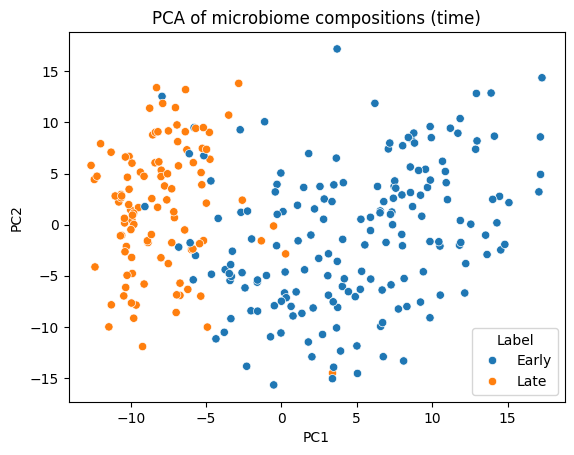

In [14]:
seaborn.scatterplot(pca_df, x='PC1', y='PC2', hue='Label')
plt.title("PCA of microbiome compositions (time)");

The microbiome seems very distinct in the two categories. 

Is the microbiome also associated with the sex of the mouse?

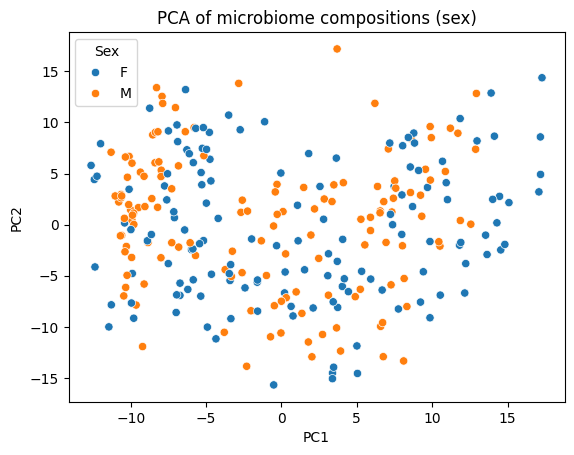

In [15]:
seaborn.scatterplot(pca_df, x='PC1', y='PC2', hue='Sex').set_title('PCA of microbiome compositions (sex)');

From our graphical exploration, it doesn't look so.

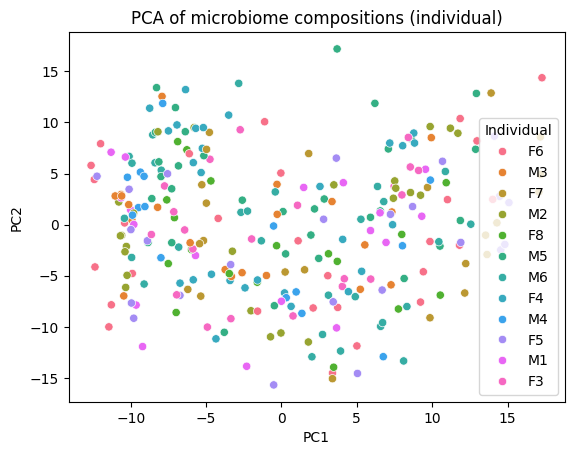

In [16]:
seaborn.scatterplot(pca_df, x='PC1', y='PC2', hue='Individual').set_title('PCA of microbiome compositions (individual)');


### t-SNE (optional)

PCA is a classical linear method that finds the geometric axis of greater variation in data and then projects them for dimensionality reduction. There are other more recent methods  like t-SNE and UMAP that can do much heavier lifting on your data and expose structure that PCA has an hard time showing. Here we show how t-SNE can improve the visualization of our dataset.

In [17]:
# t-SNE is available in scikit-learn
from sklearn.manifold import TSNE

Here we use t-SNE on the same data and highlight the clear separation between early and late samples, like PCA did:

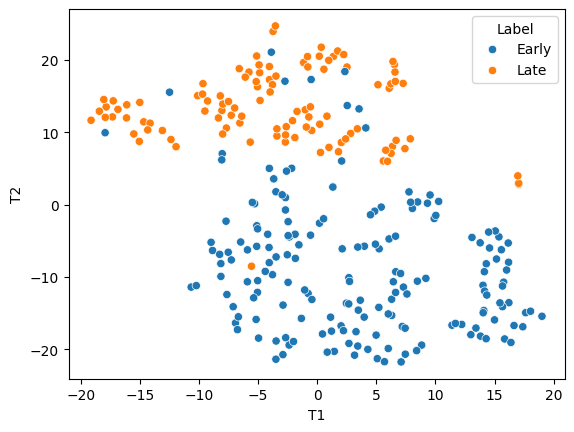

In [18]:
tsne_df = pandas.DataFrame(TSNE(n_components=2).fit_transform(log_transposed_otu_df), index=log_transposed_otu_df.index, columns=['T1', 'T2'])
tsne_df = pandas.concat([tsne_df, sample_df], axis=1)
seaborn.scatterplot(tsne_df, x='T1', y='T2', hue='Label');

By highlightning sex, we observe more defined same-sex subgroups than in PCA, so t-SNE seems to be exposing finer structural features of the dataset:

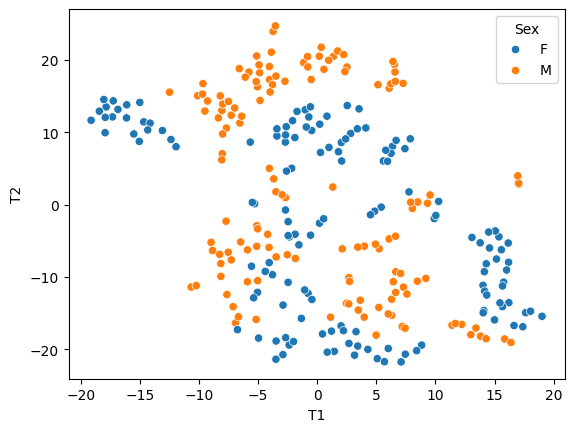

In [19]:
seaborn.scatterplot(tsne_df, x='T1', y='T2', hue='Sex');

Differently from PCA, t-SNE has some parameters that control its internal algorithm. One of these is perplexity and in the next plots we show its influence on the final visualization:

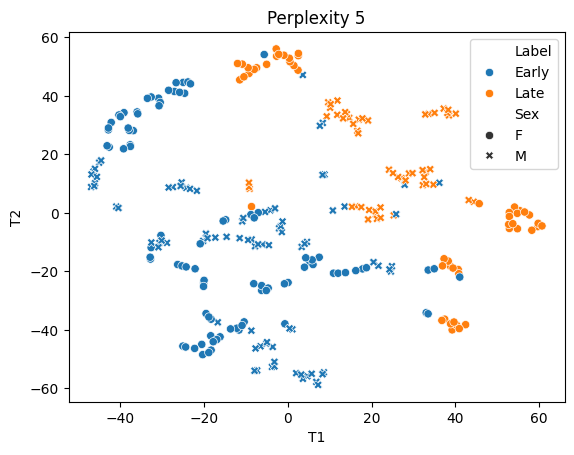

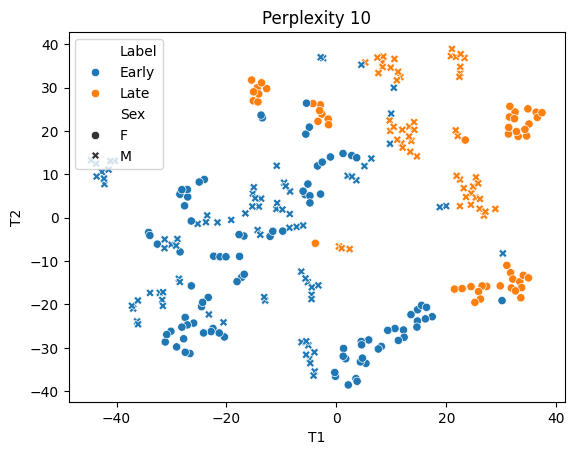

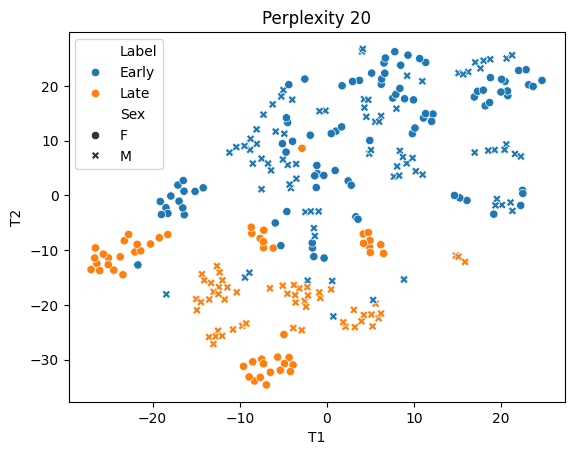

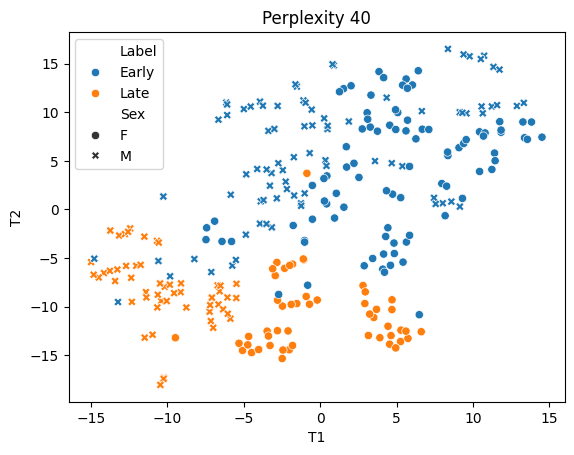

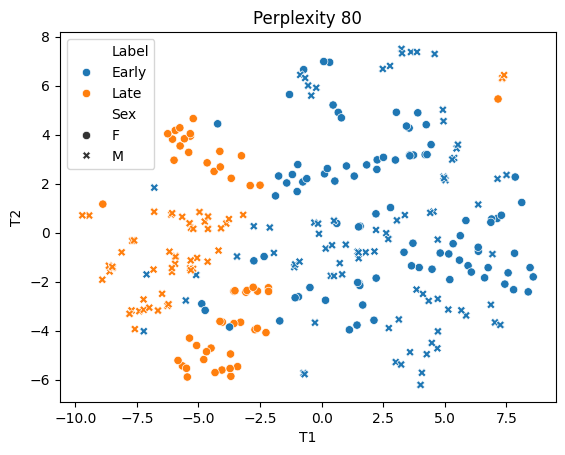

In [20]:
for perplexity in [5, 10, 20, 40, 80]:
    tsne_df = pandas.DataFrame(TSNE(n_components=2, perplexity=perplexity).fit_transform(log_transposed_otu_df), index=log_transposed_otu_df.index, columns=['T1', 'T2'])
    tsne_df = pandas.concat([tsne_df, sample_df], axis=1)
    plt.figure()
    seaborn.scatterplot(tsne_df, x='T1', y='T2', hue='Label', style='Sex')
    plt.title(f'Perplexity {perplexity}')

### UMAP
UMAP is another method that has many similarity with t-SNE.

In [21]:
# UMAP needs to be installed with the umap-learn package from the pypi repository
from umap import UMAP

As PCA and t-SNE, UMAP show a clear separation between early and late samples. However it puts late samples in different clusters, while the other methods tend to group them together:

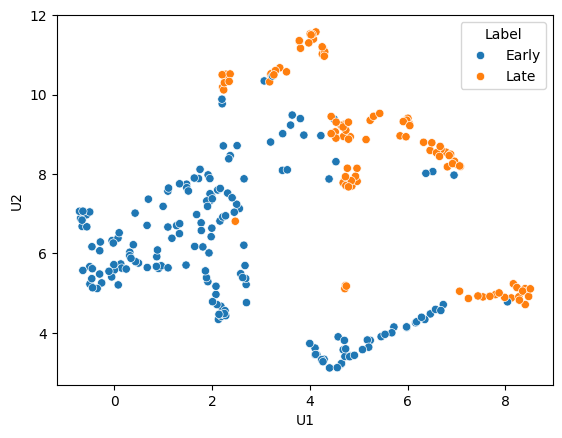

In [22]:
umap_df = pandas.DataFrame(UMAP(n_components=2).fit_transform(log_transposed_otu_df), index=log_transposed_otu_df.index, columns=['U1', 'U2'])
umap_df = pandas.concat([umap_df, sample_df], axis=1)
seaborn.scatterplot(umap_df, x='U1', y='U2', hue='Label');

Same plot highlightning sex:

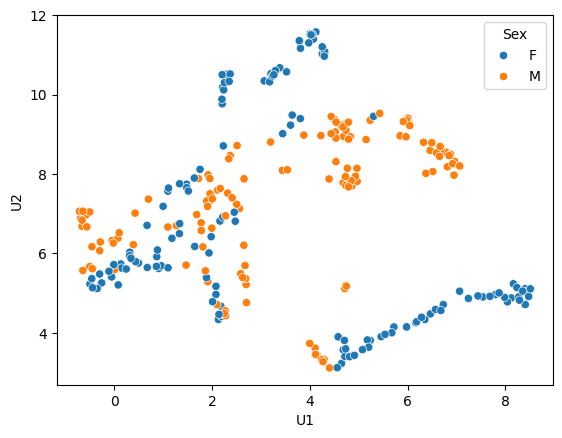

In [23]:
seaborn.scatterplot(umap_df, x='U1', y='U2', hue='Sex');

Also UMAP has parameters like t-SNE. One of them, n_neighbors, has a somewhat similar effect to perplexity in t-SNE. Here we show its impact on the visualization:

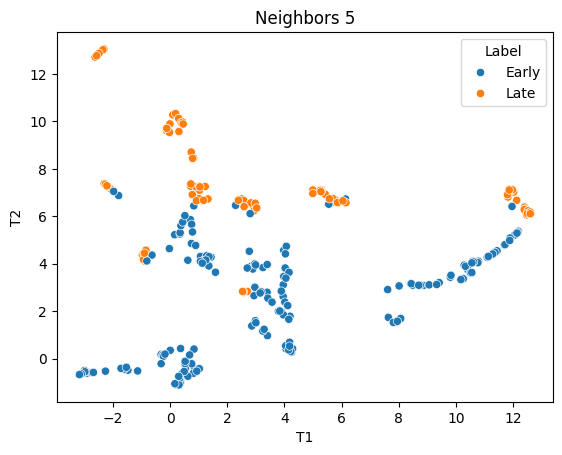

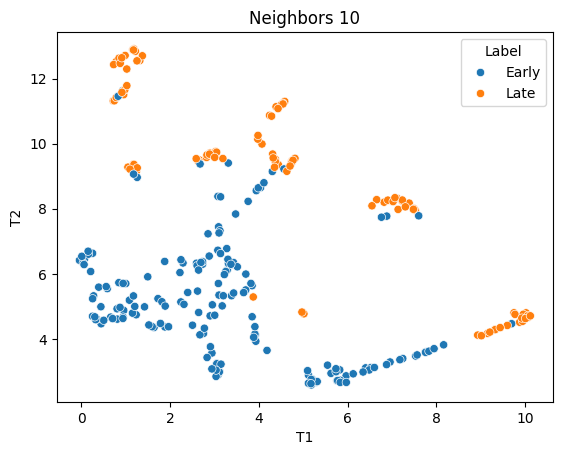

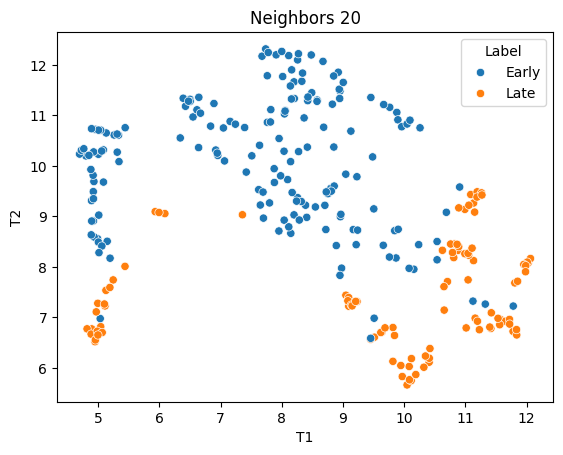

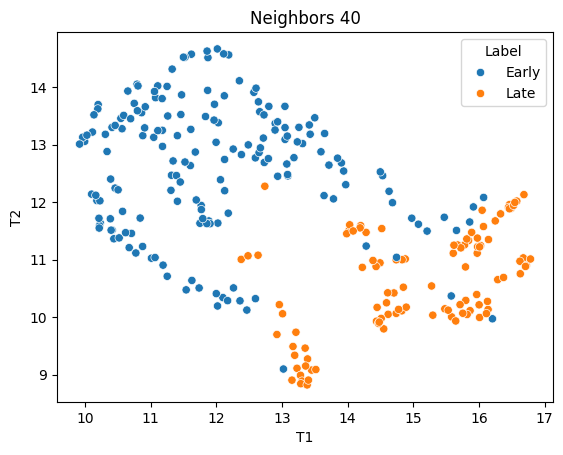

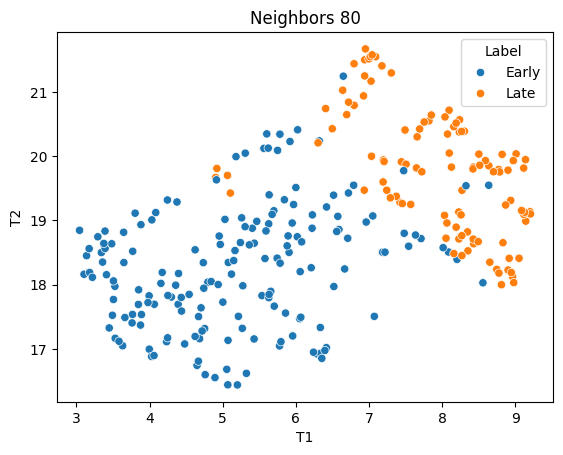

In [24]:
import matplotlib.pyplot as plt
for neigh in [5, 10, 20, 40, 80]:
    umap_df = pandas.DataFrame(UMAP(n_components=2, n_neighbors=neigh).fit_transform(log_transposed_otu_df), index=log_transposed_otu_df.index, columns=['T1', 'T2'])
    umap_df = pandas.concat([umap_df, sample_df], axis=1)
    plt.figure()
    seaborn.scatterplot(umap_df, x='T1', y='T2', hue='Label')
    plt.title(f'Neighbors {neigh}')

## A statistical test

A completely different approach to data analysis is statistical testing, which we use to find answers to very specific questions instead of generic data features. In particular, we will try to find if there are differently aboundant OTUs between early and late samples and between male and female mice.



We can use the [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)
to determine significant differences between two independent groups across various features. 

The method involves calculating p-values for each feature to assess the likelihood of observing 
the current data under the null hypothesis—that the distributions of both groups are identical. 

These p-values are compiled and sorted to identify features with significant disparities between groups, 
offering a clear insight into the data's underlying structure without delving into specific variable names or technical details.

In [56]:
# Import library for Mann-Whitney U test
from scipy.stats import mannwhitneyu

In [26]:
label_otu_pvalues = pandas.Series({
    name: mannwhitneyu(*x.groupby(sample_df['Label']).agg(list)).pvalue
    for name, x in transposed_otu_df.items()
}).sort_values()
label_otu_pvalues

seq_137    3.010841e-40
seq_109    6.531819e-38
seq_19     8.092278e-31
seq_249    2.102573e-28
seq_215    7.617253e-28
               ...     
seq_335    9.687917e-01
seq_381    9.773809e-01
seq_87     9.775869e-01
seq_57     9.842453e-01
seq_289    9.958629e-01
Length: 387, dtype: float64

Each representative sequence (OTU or ASV...) is associated with a p-value, 
indicating the statistical significance of the difference between two groups for that particular sequence.

The p-values range from extremely small (e.g., 2.087308e-40 for seq_137) to values close to 1 (e.g., 0.9944515 for seq_226), 
sorted in ascending order. 

Smaller p-values suggest strong evidence against the null hypothesis, implying significant differences between the groups for those sequences. 
In contrast, p-values near 1 indicate little to no evidence against the null hypothesis, suggesting no significant difference between the groups for those sequences.

In [27]:
sex_otu_pvalues = pandas.Series({
    name: mannwhitneyu(*x.groupby(sample_df['Sex']).agg(list)).pvalue
    for name, x in transposed_otu_df.items()
}).sort_values()
sex_otu_pvalues

seq_30     1.446872e-21
seq_112    6.304726e-21
seq_14     2.071089e-15
seq_60     1.150330e-13
seq_100    5.803291e-13
               ...     
seq_190    9.715436e-01
seq_67     9.759455e-01
seq_361    9.928943e-01
seq_383    9.959770e-01
seq_316    1.000000e+00
Length: 387, dtype: float64

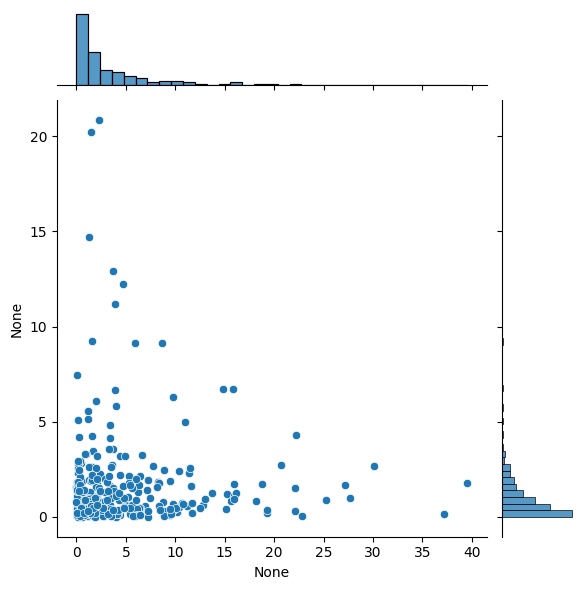

In [28]:
jplot = seaborn.jointplot(x=-numpy.log10(label_otu_pvalues), y=-numpy.log10(sex_otu_pvalues))

## Supervised approach

In this section, we explore the application of machine learning to our dataset using a **Random Forest Classifier**
(see our previous [workshop by Dipali Singh](https://drive.google.com/drive/folders/1UY6pvTyzaAuNIgJfXMwIWCEBryKdcVdb)).

Note that we will use two *labels*:
* "Label" (can be "Early" or "Late)
* "Sex" (can be "Male" or "Female")

As we noticed, there is a clear separation among *Early* and *Late* samples.

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
y_label = sample_df.loc[transposed_otu_df.index, 'Label']
y_sex = sample_df.loc[transposed_otu_df.index, 'Sex']
individual = sample_df.loc[transposed_otu_df.index, 'Individual']

Early/late classification on the whole dataset:

In [31]:
RandomForestClassifier(random_state=0).fit(log_transposed_otu_df, y_label).score(log_transposed_otu_df, y_label)

1.0

Female/Male classification on the whole dataset is also very good (despite what previous sections may have suggested):

In [32]:
RandomForestClassifier(random_state=0).fit(log_transposed_otu_df, y_sex).score(log_transposed_otu_df, y_sex)

1.0

Impressive, or "too good to be true"?

### Splitting Data for Training and Testing

Following the initial model evaluation, we proceed to split our dataset into training and testing sets using the `train_test_split` method. 
This crucial step divides the dataset into separate parts: one for training the Random Forest Classifier and another for testing its performance on unseen data. 

The shape attributes of `X_train` and `X_test` are examined to understand the distribution of data between the training and testing phases.
Subsequently, a new Random Forest Classifier is trained on the training set and its accuracy is evaluated on the test set. 

This process not only validates the model's ability to generalize to new data but also provides insights into its predictive accuracy, helping identify potential overfitting or underfitting issues.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(log_transposed_otu_df, y_label)
# Let's see the "shape" of these tables
X_train.shape, X_test.shape

((210, 387), (71, 387))

The first pair (211, 387) refers to the size of the **training dataset** (X_train). 
It means that there are 211 samples or rows, and each sample has 387 features or columns. This is the larger portion of the dataset and is used to train or teach the model.

The second pair (71, 387) refers to the size of the **testing dataset** (X_test). 
It indicates that there are 71 samples or rows, and like the training set, each sample has 387 features or columns. This portion of the dataset is used to test or evaluate how well the model has learned from the training dataset.

In [35]:
RandomForestClassifier(random_state=0).fit(X_train, y_train).score(X_test, y_test)

0.971830985915493

Here we use the default metric of the score() method, which for RandomForestClassifier and other classification methods is accuracy. To use another metric we can do it "by hand" and explicitly compute the predictions:

In [36]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
predictions = model.predict(X_test)
predictions

array(['Early', 'Late', 'Early', 'Late', 'Late', 'Early', 'Early', 'Late',
       'Late', 'Early', 'Late', 'Early', 'Early', 'Early', 'Late',
       'Early', 'Early', 'Late', 'Late', 'Early', 'Early', 'Late', 'Late',
       'Early', 'Late', 'Early', 'Late', 'Late', 'Early', 'Early', 'Late',
       'Early', 'Early', 'Late', 'Early', 'Late', 'Early', 'Late',
       'Early', 'Early', 'Late', 'Late', 'Early', 'Early', 'Early',
       'Early', 'Late', 'Early', 'Early', 'Early', 'Early', 'Early',
       'Early', 'Late', 'Late', 'Early', 'Early', 'Late', 'Late', 'Late',
       'Early', 'Late', 'Early', 'Early', 'Early', 'Early', 'Early',
       'Late', 'Early', 'Early', 'Early'], dtype=object)

You can also get a numeric prediction, where values close to 1.0 are positive (in this case "Late") and values close to 0.0 are negative (in this case "Early"):

In [37]:
prob_predictions = model.predict_proba(X_test)[:, 1]
prob_predictions

array([0.09, 0.63, 0.04, 0.9 , 0.75, 0.02, 0.26, 0.94, 0.61, 0.05, 0.96,
       0.02, 0.02, 0.02, 0.52, 0.15, 0.03, 0.8 , 0.92, 0.25, 0.23, 0.68,
       0.8 , 0.08, 0.68, 0.08, 0.61, 0.9 , 0.05, 0.17, 0.85, 0.02, 0.4 ,
       0.88, 0.17, 0.85, 0.04, 0.92, 0.04, 0.09, 0.85, 0.85, 0.08, 0.18,
       0.23, 0.03, 0.97, 0.04, 0.07, 0.03, 0.1 , 0.08, 0.11, 0.92, 0.92,
       0.06, 0.23, 0.67, 0.77, 0.83, 0.14, 0.72, 0.11, 0.06, 0.01, 0.24,
       0.34, 0.86, 0.21, 0.02, 0.3 ])

We can now use different metrics, like accuracy and balanced accuracy (which avoids overestimating classification performance when classes have different sizes)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.971830985915493

In [39]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions)

0.9777777777777779

While both accuracy and balanced accuracy give a score of 0.5 to a random prediction and 1.0 to a perfect one, Matthew's correlation coefficient give a score of 0.0 for a random prediction (still 1.0 for perfection), so we still get a high result:

In [40]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions)

0.9419668716582273

The area under the ROC curve is also a very common metric for binary classification. Instead of predicted labels, it needs a ranking, so we use the prob_prediction. Also AUC ranges from 0.5 for random to 1.0, but it is usually higher than accuracy:

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, prob_predictions)

0.9948717948717949

### Repeated train-test split


In the next section, we conduct an experiment to further assess the performance of our model. By repeating the process of dividing our dataset into training and testing sets ten times, we train and test a Random Forest Classifier on each new split. For each iteration, we note the model's accuracy score on the test data, providing us with ten separate evaluations.

In this way we have a more accurate estimate of the performance of the model.

In [42]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(log_transposed_otu_df, y_label)
    accuracy = RandomForestClassifier(random_state=0).fit(X_train, y_train).score(X_test, y_test)
    scores.append(accuracy)
scores

[0.9436619718309859,
 0.971830985915493,
 0.9859154929577465,
 0.9859154929577465,
 0.9859154929577465,
 0.9577464788732394,
 0.9295774647887324,
 0.9859154929577465,
 0.971830985915493,
 0.9154929577464789]

It's important to observe the variability: if we only assess the accuracy once, we can get a misleadingly high or low number out of a specific train-test split.

This final step helps us understand how well the model performs when trained and evaluated on the same data, offering a comparison point to the earlier cross-validation results.

In [43]:
print(f"Mean accuracy = {numpy.mean(scores):.3f} ± {numpy.std(scores):.3f}")

Mean accuracy = 0.963 ± 0.025


### A prediction on another variable: sex


After completing these iterations, we train another Random Forest Classifier on the entire dataset and assess its accuracy in predicting a specific outcome (indicated by y_sex). 

In [62]:
sex_scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(log_transposed_otu_df, y_sex)
    accuracy = RandomForestClassifier(
        random_state=0).fit(
        X_train, y_train).score(
        X_test, y_test)
    sex_scores.append(accuracy)
sex_scores

[0.8450704225352113,
 0.9295774647887324,
 0.9295774647887324,
 0.8873239436619719,
 0.9295774647887324,
 0.9014084507042254,
 0.8450704225352113,
 0.9295774647887324,
 0.8169014084507042,
 0.9436619718309859]

As we can see, sex is harder to predict than the early/late label:

In [45]:
print(f"Mean accuracy = {numpy.mean(sex_scores):.3f} ± {numpy.std(sex_scores):.3f}")

Mean accuracy = 0.889 ± 0.042


### Still too optimistic?

Looking at our dataset someone might argue that, as quite a few samples are taken from each mouse, having samples from the same mouse in both the train and test set might give some advantage to our Random Forest instead of having to predict on mice that it has never seen before. Especially for sex, if our model can recognize the donor of a sample, then it likely it already knows its sex from having seen it in training. Then our model may not work as well (or fail completely) on new samples from new mice! We need to check this!

For simplicity, we use cross-validation instead of train-test split here because it provides ready-made splitting mechanics that keeps groups together. In this instance we want to keep all samples form the same mouse together in the same split.

Here is a simple cross-validation example without checking for donors, for label and sex:

In [46]:
from sklearn.model_selection import cross_val_score

In [58]:
cross_val_score(
    RandomForestClassifier(random_state=0), 
    log_transposed_otu_df, 
    y_label).mean()

0.9642857142857142

In [59]:
cross_val_score(
    RandomForestClassifier(random_state=0), 
    log_transposed_otu_df, 
    y_sex).mean()

0.9145363408521303

As you can see, we get accuracy estimates that are comparable to those from the repeated train-test split. Now we use GroupKFold, so that our cross-validation does not put samples from the same donor in different folds:

In [49]:
from sklearn.model_selection import GroupKFold

In [50]:
cross_val_score(
    RandomForestClassifier(random_state=0), 
    log_transposed_otu_df, 
    y_label, 
    groups=individual, 
    cv=GroupKFold()).mean()

0.9557515597147951

In [51]:
cross_val_score(
    RandomForestClassifier(random_state=0), 
    log_transposed_otu_df, 
    y_sex, 
    groups=individual, 
    cv=GroupKFold()).mean()

0.6292738413547238

Indeed, performance on sex has a very large drop, while performance on label has minimal changes. This shows that our previous estimates of sex predictability where largely inflated due to using testing sets that were not really blind. Thus, our Random Forest for sex prediction is overfitting quite badly, even if its predicition are still not completely random.

### Continuous Outcome Prediction

In this section, we delve into predictive modeling for continuous outcomes using the `RandomForestRegressor`,
focusing on predicting the 'Day' variable from our dataset. 
Initially, we fit and assess the model's performance directly on our data, targeting the continuous '**Day**' variable as our prediction goal (i.e. number of days after wheaning, that was previously used as a categorical label Early/Late).

To validate our model's accuracy and generalizability, we employ two cross-validation strategies: [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn-model-selection-kfold) and [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html). 

* The KFold method provides a basic evaluation by partitioning the data into folds for systematic training and testing. To address the challenge of repeated observations from the same individuals, we then apply GroupKFold. 
* GroupKFold ensures that all data from an individual is either in the training set or the testing set, offering a more realistic assessment of the model’s performance on entirely new data.

These steps aim to refine our understanding of the RandomForestRegressor’s predictive capability, especially in a context where the independence of observations is crucial for accurate model evaluation.

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Extract the 'Day' column from 'sample_df' for rows that match the index of 'log_transposed_otu_df' as the target variable.
y_day = sample_df.loc[log_transposed_otu_df.index, 'Day']

Create a RandomForestRegressor, fit it to the data, and then calculate and return the coefficient of determination (R^2) of the prediction.

In [57]:
RandomForestRegressor().fit(
    log_transposed_otu_df, y_day
).score(log_transposed_otu_df, y_day)

0.972640131988851

Perform cross-validation using a RandomForestRegressor, returning the mean score of the cross-validated groups with **KFold** cross-validator (cv=).

In [54]:
cross_val_score(
    RandomForestRegressor(), 
    log_transposed_otu_df, y_day
).mean()

0.8013049735709566

Perform cross-validation using a RandomForestRegressor, but with the **GroupKFold** cross-validator to take into account groupings specified by 'individual'.

In [55]:
cross_val_score(
    RandomForestRegressor(), 
    log_transposed_otu_df, 
    y_day, 
    groups=individual, 
    cv=GroupKFold()
).mean()

0.7944217832975239

Are we good enough in predicting the variable?

The improvement in the score from KFold to GroupKFold (from 0.7965 to 0.8098) suggests that accounting for groupings within your data leads to a more accurate model. 
This is likely because GroupKFold prevents information leakage between the training and testing sets by ensuring that data from the same group (e.g., the same individual) are all in either the training set or the testing set but not split across both.
 